# ========================== Imports ==================== #

In [0]:
import gym
from keras import models
from keras import layers
from keras.optimizers import Adam
from collections import deque
import random
import numpy as np
import copy 

import matplotlib.pyplot as plt
from time import *

# ========================== env ==================== #


In [0]:
env = gym.make('MountainCar-v0')

# ===================== parameter ==================== #


In [16]:
gamma=0.99
learingRate=0.001
episodeNum=10000
stepNum=201 #max is 200 #steps in one episode

epsilon = 1
epsilon_min=0.01
epsilon_decay = 0.01
epsilon_decay = (epsilon-epsilon_min)/episodeNum
print(epsilon_decay)
targetNetworkUpdateRate=10

replayBuffer=deque(maxlen=20000)
numPickFromBuffer=32

9.9e-05


In [0]:
# ================ just for testing =================#

# print(env.observation_space.shape,env.action_space.n,env.action_space)
# print(env.observation_space.high,env.observation_space.low)


# ar = [3,2,1,0]
# for i,ele in enumerate(ar):
#   print(i,ele)



# state=env.reset().reshape(1,2)
# print(state)
# trainNetwork.predict(state)[0]



# print("episode : %.3d ,     epsilon is %.2f,     reward is %d,     maxPosition is %.2f"%(58,11.111,11.111,11.111))




# print(env.reset(),env.reset().shape)
# env.reset().reshape(1,2)

# ========================== Creating network ==================== #

In [0]:
def createNetwork():
    global gamma,learingRate,stepNum,epsilon,epsilon_decay,epsilon_min,numPickFromBuffer,replayBuffer,trainNetwork,targetNetwork,targetNetworkUpdateRate
    model = models.Sequential()
    state_shape = env.observation_space.shape
    model.add(layers.Dense(24, activation='relu', input_shape=state_shape))
    model.add(layers.Dense(48, activation='relu'))
    model.add(layers.Dense(env.action_space.n,activation='linear'))
    model.compile(loss='mse', optimizer=Adam(lr=learingRate))
    return model

# ============ Helper Function (epsilonGreedy, training) =============== #

In [0]:
def epsilonGreedy(state):
    global gamma,learingRate,stepNum,epsilon,epsilon_decay,epsilon_min,numPickFromBuffer,replayBuffer,trainNetwork,targetNetwork,targetNetworkUpdateRate
    epsilon = max(epsilon_min, epsilon)
    if np.random.rand(1) < epsilon:
        action = np.random.randint(0, 3)
    else:
        action=np.argmax(trainNetwork.predict(state)[0])
    return action

def learn():
    global gamma,learingRate,stepNum,epsilon,epsilon_decay,epsilon_min,numPickFromBuffer,replayBuffer,trainNetwork,targetNetwork,targetNetworkUpdateRate
    if len(replayBuffer) < numPickFromBuffer:
        return
    samples = random.sample(replayBuffer,numPickFromBuffer)
    states,newStates = [],[]
    for sample in samples:
        state, action, reward, new_state, done = sample
        states.append(state)
        newStates.append(new_state)
    states = np.array(states).reshape(numPickFromBuffer, 2)
    newStates = np.array(newStates).reshape(numPickFromBuffer, 2)
    #[  [Q(s1,a1), Q(s1,a2), Q(s1,a3)],
    #   [Q(s2,a1), Q(s2,a2), Q(s2,a3)],
    #   [Q(s3,a1), Q(s3,a2), Q(s3,a3)]  ]
    y_Qs = trainNetwork.predict(states)
    y_Qs_dash=targetNetwork.predict(newStates) #similarly Q[s',a1..a2...] for states
    y_Qs_star = copy.deepcopy(y_Qs) # initialise as of now, to be calculate later

    for j,sample in enumerate(samples):
        state, action, reward, new_state, done = sample
        if done:
            y_Qs_star[j][action] = reward
        else:
            y_Qs_star[j][action] = reward + gamma * max(y_Qs_dash[j])

    return trainNetwork.fit(states, y_Qs_star, epochs=1, verbose=0)

# ========================== Main DQN ==================== #


In [0]:
def DQN():
  
  global gamma,learingRate,stepNum,epsilon,epsilon_decay,epsilon_min,numPickFromBuffer,replayBuffer,trainNetwork,targetNetwork,targetNetworkUpdateRate
  
  trainNetwork=createNetwork()
  targetNetwork=createNetwork()
  targetNetwork.set_weights(trainNetwork.get_weights())

  rlist = []
  avgrlist = []
  for eps in range(episodeNum): #for all episode
    state=env.reset().reshape(1,2) 
    rewardSum = 0
    max_position=-99
    for i in range(stepNum):  #for max stepNum no. of step
        action = epsilonGreedy(state)
        # if eps%50==0: #show the animation every 50 eps
        #     env.render()
        new_state, reward, done, _ = env.step(action)
        new_state = new_state.reshape(1, 2)
        max_position = max(max_position, new_state[0][0]) # Keep track of max position
        if new_state[0][0] >= 0.5: # Adjust reward for task completion
            reward += 10
        replayBuffer.append([state, action, reward, new_state, done]) #store in replay memory
        
        learn()
        rewardSum += reward
        state = new_state
        if done:
            break

    rlist.append(rewardSum)
    
    # print("episode : %.3d ,    epsilon is %.2f,      reward is %d,      maxPosition is %.2f"%(eps,epsilon, rewardSum,max_position))

    #====== avg reward per 100 episodes =====#
    if (eps+1) % 100 == 0:
        avgr = np.mean(rlist)
        avgrlist.append(avgr)
        rlist = []
        # print('\n *************** Episode {} Average Reward: {} ******************* \n'.format(eps+1, avgr))
        print("episode : %.3d ,    epsilon is %.2f,      reward is %d,      maxPosition is %.2f"%(eps+1,epsilon, avgr, max_position))

    
    if eps % targetNetworkUpdateRate == 0: #update target network
      targetNetwork.set_weights(trainNetwork.get_weights())
    
    #====== epsilion decay =====#
    if epsilon > epsilon_min:
            epsilon -= epsilon_decay

  return avgrlist

# ========================== RUN ==================== #


In [21]:
avgrlist = DQN()

episode : 100 ,    epsilon is 0.99,      reward is -200,      maxPosition is -0.38
episode : 200 ,    epsilon is 0.98,      reward is -200,      maxPosition is -0.35
episode : 300 ,    epsilon is 0.97,      reward is -200,      maxPosition is -0.42
episode : 400 ,    epsilon is 0.96,      reward is -200,      maxPosition is -0.37
episode : 500 ,    epsilon is 0.95,      reward is -200,      maxPosition is -0.39
episode : 600 ,    epsilon is 0.94,      reward is -200,      maxPosition is -0.41
episode : 700 ,    epsilon is 0.93,      reward is -200,      maxPosition is -0.46
episode : 800 ,    epsilon is 0.92,      reward is -200,      maxPosition is -0.28
episode : 900 ,    epsilon is 0.91,      reward is -200,      maxPosition is -0.41
episode : 1000 ,    epsilon is 0.90,      reward is -200,      maxPosition is -0.40
episode : 1100 ,    epsilon is 0.89,      reward is -200,      maxPosition is -0.37
episode : 1200 ,    epsilon is 0.88,      reward is -200,      maxPosition is -0.28
e

# ========================== PLOT ==================== #


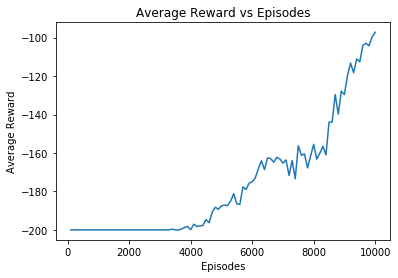

In [22]:
#========================================== plot and save ==================================#
plt.plot(100*(np.arange(len(avgrlist)) + 1), avgrlist)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
plt.show()
# plt.savefig('rewards/'+'epsd_'+str(e)+'_lr_'+str(lr)+'_epsln_'+str(ep)+'_gamma_'+str(gamma)+'.jpg')
plt.close()

# ========================== model summary ==================== #


In [0]:
# !ls
# from keras.models import load_model
# model = load_model('trainNetworkInEPS999.h5')
# model.summary()
# from keras.utils import plot_model
# plot_model(model, to_file='model.png')